# 1.0 Projected revenue per client

In [72]:
# import dependencies

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\denis\AppData\Local\Temp\ipykernel_1776\816365406.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [73]:
# Read in file
df = pd.read_csv('train_V2_cleaned.csv')

# Convert dummy features
df.iloc[:,24:62] = df.iloc[:,24:62].astype('category')

# Show conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   income_am              4947 non-null   float64 
 1   profit_last_am         4947 non-null   float64 
 2   profit_am              4947 non-null   float64 
 3   damage_am              4947 non-null   float64 
 4   damage_inc             4947 non-null   int64   
 5   crd_lim_rec            4947 non-null   float64 
 6   cab_requests           4947 non-null   int64   
 7   married_cd             4947 non-null   int64   
 8   bar_no                 4947 non-null   int64   
 9   age                    4947 non-null   int64   
 10  client_segment         4947 non-null   int64   
 11  sect_empl              4947 non-null   int64   
 12  fam_adult_size         4947 non-null   int64   
 13  children_no            4947 non-null   int64   
 14  tenure_mts             4947 non-null   i

## 1.1 Train/test-spit and standardisation

### 1.1.1 Shuffle data

In [74]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### 1.1.2 Train/test-split

In [75]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['outcome_profit'],1)
y = df_shuffle['outcome_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

C:\Users\denis\AppData\Local\Temp\ipykernel_1776\3570332103.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_profit'],1)


### 1.1.3 Standardise

In [76]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

X_train_stand[num_feat] = scaler.fit_transform(X_train[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

## 1.2 Polynomial regression

### 1.2.1 Cross-validation

In [77]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.002516610466007574
Order 1: avg R^2 = 0.27812926270463667
Order 2: avg R^2 = -3.2293747537118383e+20


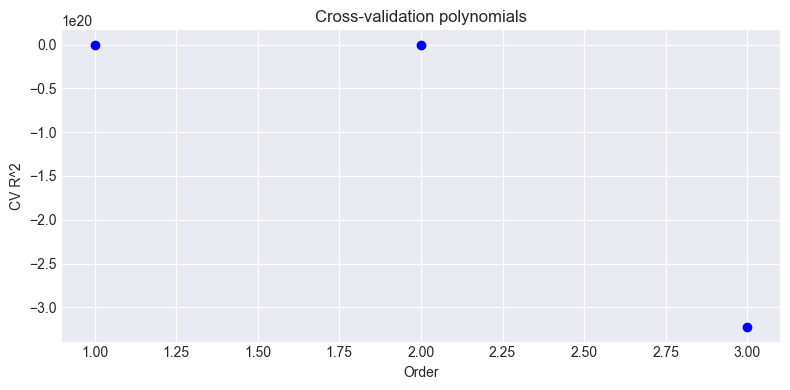

In [78]:
# Plotting the results

fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [79]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 1


In [80]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
reg_poly2.fit(X_train, y_train)
print(reg_poly2.score(X_train, y_train))
print(reg_poly2.score(X_test, y_test))

0.3816909519651771
0.39995536480227023


# 1.3 K-nearest Neighbors

## 1.3.1 Cross-validation

In [81]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

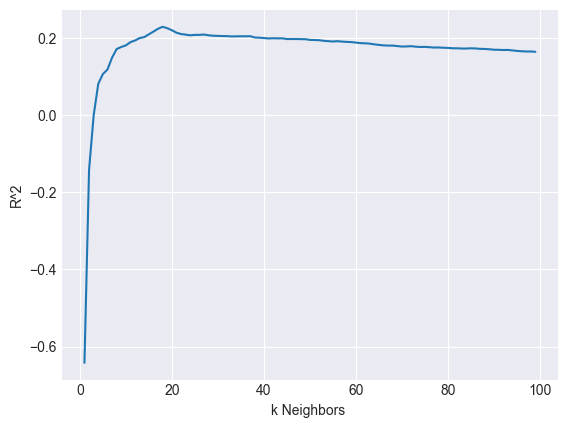

The best k is 18


In [82]:
# Plotting the results

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

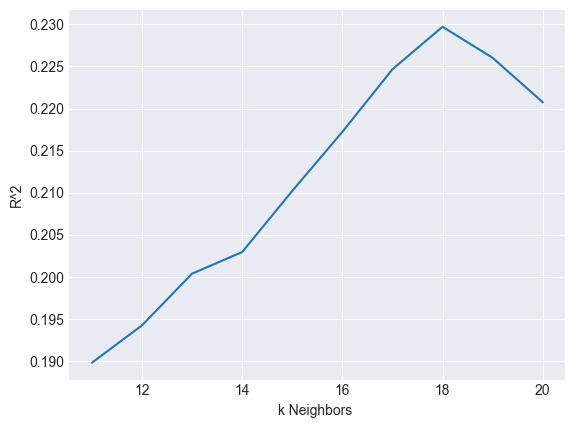

The best k is 18
The best validated score is 0.22969766742364056


In [83]:
# let's zoom in to the nearest 45-55

plt.plot(K[10:20],cv_scores[10:20])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])
print('The best validated score is', max_value)

In [84]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)
print(f'train value for k={K[max_index]}:', knn.fit(X_train_stand, y_train))
print(f'test value for k={K[max_index]}:', knn.score(X_test_stand, y_test))

train value for k=18: KNeighborsRegressor(n_neighbors=18)
test value for k=18: 0.30193631980065005


## 1.4 Radius Nearest Neighbors

### 1.4.1 Cross-validation

c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\metrics\_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\skl

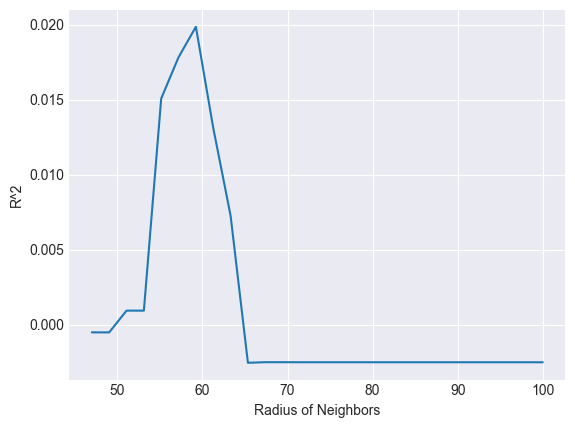

In [85]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(0.1,100,50)   
# This will give an array of numbers between 1 and 100 cross-validating using 50 values

cv_scores = []
sd_scores = []

# using a different radius each iteration. This will calculate and check which on in the best.

for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius= k)
    scores = cross_val_score(Rnn, X_train_stand, y_train,  cv=5)
    
    # store the average score
    cv_scores.append(scores.mean())
    
    # store the standard deviation of the score
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))


# plotting
plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors')
plt.ylabel('R^2')
plt.show()